In [1]:
import pandas as pd
from Bio.Seq import Seq
from Bio import SeqIO

In [12]:
def extract_proteins(gb_file):
    proteins = []
    for record in SeqIO.parse(gb_file, "genbank"):
        for feature in record.features:
            if feature.type == "CDS":
                if "translation" in feature.qualifiers:
                    protein_id = feature.qualifiers["protein_id"][0]
                    translation = feature.qualifiers["translation"][0]
                    seq = SeqIO.SeqRecord(
                        Seq(translation),
                        id=protein_id,
                        description=""
                    )
                    proteins.append(seq)
    return proteins


ucyna_proteins = extract_proteins("../genomes/ucyna.gb")
crocosphaera_proteins = extract_proteins("../genomes/crocosphaera.gb")

print(f"Found {len(ucyna_proteins)} proteins in UCYN-A genome")
print(f"Found {len(crocosphaera_proteins)} proteins in Crocosphaera genome")

Found 1186 proteins in UCYN-A genome
Found 4942 proteins in Crocosphaera genome


In [13]:
# save ucyna proteins to fasta file
SeqIO.write(ucyna_proteins, "../results/ucyna_proteins.fasta", "fasta")
SeqIO.write(crocosphaera_proteins, "../data/crocosphaera_proteins.fasta", "fasta")

4942

### Find reciprocal best hits

In [2]:
df = pd.read_csv('../results/bidirectional-blast.csv')

In [3]:
directions = list(df["direction"].unique())
genome_names = [d.split(" -> ")[0] for d in directions]

In [4]:
# Filter out low quality matches
min_identity = 70
e_cutoff = 1e-30

quality_matches = df[
    (df["evalue"] <= e_cutoff)
].copy()
print(f"Discarded {(1 - len(quality_matches) / len(df)) * 100:.2f}% of matches")

Discarded 20.11% of matches


In [5]:
# Separate the two directions
forward = quality_matches[quality_matches["direction"] == directions[0]]
reverse = quality_matches[quality_matches["direction"] == directions[1]]
print(f"{directions[0]}: {len(forward)}; {directions[1]}: {len(reverse)}")

crocosphaera -> ucyna: 1348; ucyna -> crocosphaera: 1099


In [8]:
# Get the best match for each query
forward_best = forward.sort_values(
    ["bit_score", "percent_identity"], ascending=[False, False]
).drop_duplicates("query_id", keep="first")
reverse_best = reverse.sort_values(
    ["bit_score", "percent_identity"], ascending=[False, False]
).drop_duplicates("query_id", keep="first")

# Find reciprocal best hits
rbh_pairs = []
for _, forward_hit in forward_best.iterrows():
    # Get the corresponding reverse hit (if it exists)
    reverse_hit = reverse_best[
        (reverse_best["query_id"] == forward_hit["subject_id"])
        & (reverse_best["subject_id"] == forward_hit["query_id"])
    ]

    if not reverse_hit.empty:
        rbh_pairs.append(
            {
                f"{genome_names[0]}_gene_id": forward_hit["query_id"],
                f"{genome_names[1]}_gene_id": forward_hit["subject_id"],
                "percent_identity_forward": forward_hit["percent_identity"],
                "percent_identity_reverse": reverse_hit.iloc[0]["percent_identity"],
                "bit_score_forward": forward_hit["bit_score"],
                "bit_score_reverse": reverse_hit.iloc[0]["bit_score"],
                "evalue_forward": forward_hit["evalue"],
                "evalue_reverse": reverse_hit.iloc[0]["evalue"],
            }
        )

rhb_pairs = pd.DataFrame(rbh_pairs)
print(f"Found {len(rbh_pairs)} reciprocal best hits")

Found 1098 reciprocal best hits


In [9]:
rhb_pairs

,crocosphaera_gene_id,ucyna_gene_id,percent_identity_forward,percent_identity_reverse,bit_score_forward,bit_score_reverse,evalue_forward,evalue_reverse
0,WP_243397439.1,BDA39804.1,73.0,73.0,2290.0,2288.0,0.000000e+00,0.000000e+00
1,WP_009543584.1,BDA39805.1,82.3,82.3,2226.0,2231.0,0.000000e+00,0.000000e+00
2,WP_009545345.1,BDA40003.1,82.4,82.1,2110.0,2120.0,0.000000e+00,0.000000e+00
3,WP_009545344.1,BDA40002.1,95.5,95.5,2076.0,2075.0,0.000000e+00,0.000000e+00
4,WP_009545838.1,BDA39937.1,82.0,82.0,1771.0,1780.0,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...
1093,WP_009543613.1,BDA39736.1,71.4,71.4,102.0,103.0,2.870000e-32,5.600000e-32
1094,WP_009545667.1,BDA39857.1,61.8,61.8,101.0,103.0,2.510000e-31,1.740000e-31
1095,WP_009545604.1,BDA39531.1,68.8,68.8,100.0,107.0,1.710000e-31,1.200000e-33
1096,WP_009543888.1,BDA39235.1,72.6,70.1,99.8,102.0,4.840000e-31,2.350000e-31


In [14]:
len(rhb_pairs)/len(ucyna_proteins)

0.9258010118043845

### Identify proteins missing from UCYN-A but present in Crocosphaera

In [15]:
matching_protein_ids = set(rhb_pairs["crocosphaera_gene_id"].tolist())

ucyna_missing = [ p for p in crocosphaera_proteins if p.id not in matching_protein_ids ]
len(ucyna_missing)

3844

In [16]:
# Write missing proteins to fasta file
SeqIO.write(ucyna_missing, "../results/ucyna_missing.fasta", "fasta")

3844

In [17]:
# Read InterProScan results
df = pd.read_csv('../results/ucyna_missing_interpro.tsv', sep='\t')

# Columns:
df.columns = [
    "accession",
    "sequence_md5",
    "sequence_length",
    "analysis",
    "signature_accession",
    "signature_description",
    "start",
    "stop",
    "score",
    "status",
    "date",
    "interpro_accession",
    "interpro_description",
    "go",
    "pathway",
]
df

,accession,sequence_md5,sequence_length,analysis,signature_accession,signature_description,start,stop,score,status,date,interpro_accession,interpro_description,go,pathway
0,BDA40072.1,291783f16d4ca004c5da350d2e321592,237,NCBIfam,TIGR03060,photosystem II biogenesis protein Psp29,1,218,1.3E-67,T,22-11-2024,IPR017499,Protein Thf1,GO:0010207(InterPro)|GO:0015979(InterPro),-
1,BDA40072.1,291783f16d4ca004c5da350d2e321592,237,Coils,Coil,Coil,154,185,-,T,22-11-2024,-,-,-,-
2,BDA40072.1,291783f16d4ca004c5da350d2e321592,237,Pfam,PF11264,Thylakoid formation protein,6,221,4.3E-76,T,22-11-2024,IPR017499,Protein Thf1,GO:0010207(InterPro)|GO:0015979(InterPro),-
3,BDA40072.1,291783f16d4ca004c5da350d2e321592,237,Hamap,MF_01843,Protein Thf1 [thf1].,1,219,28.338745,T,22-11-2024,IPR017499,Protein Thf1,GO:0010207(InterPro)|GO:0015979(InterPro),-
4,BDA39184.1,0542b9419117b9e92a5ec3bbb0b67e67,598,Pfam,PF00395,S-layer homology domain,90,131,0.032,T,22-11-2024,IPR001119,S-layer homology domain,-,MetaCyc:PWY-1822|MetaCyc:PWY-5497|MetaCyc:PWY-...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10306,BDA40232.1,f80a1e14ff292afb671dee8582265c7f,156,Gene3D,G3DSA:1.10.455.10,Ribosomal protein S7 domain,1,155,2.9E-61,T,22-11-2024,IPR036823,Small ribosomal subunit protein uS7 domain sup...,-,Reactome:R-BTA-156827|Reactome:R-BTA-1799339|R...
10307,BDA40232.1,f80a1e14ff292afb671dee8582265c7f,156,Hamap,MF_00480_B,Small ribosomal subunit protein uS7 [rpsG].,1,156,34.576679,T,22-11-2024,IPR005717,"Small ribosomal subunit protein uS7, bacterial...",GO:0003735(InterPro)|GO:0006412(InterPro)|GO:0...,-
10308,BDA40232.1,f80a1e14ff292afb671dee8582265c7f,156,ProSitePatterns,PS00052,Ribosomal protein S7 signature.,20,46,-,T,22-11-2024,IPR020606,"Small ribosomal subunit protein uS7, conserved...",GO:0003723(InterPro)|GO:0003735(InterPro)|GO:0...,Reactome:R-BTA-156827|Reactome:R-BTA-1799339|R...
10309,BDA40232.1,f80a1e14ff292afb671dee8582265c7f,156,FunFam,G3DSA:1.10.455.10:FF:000001,30S ribosomal protein S7,1,155,3.8E-70,T,22-11-2024,-,-,-,-


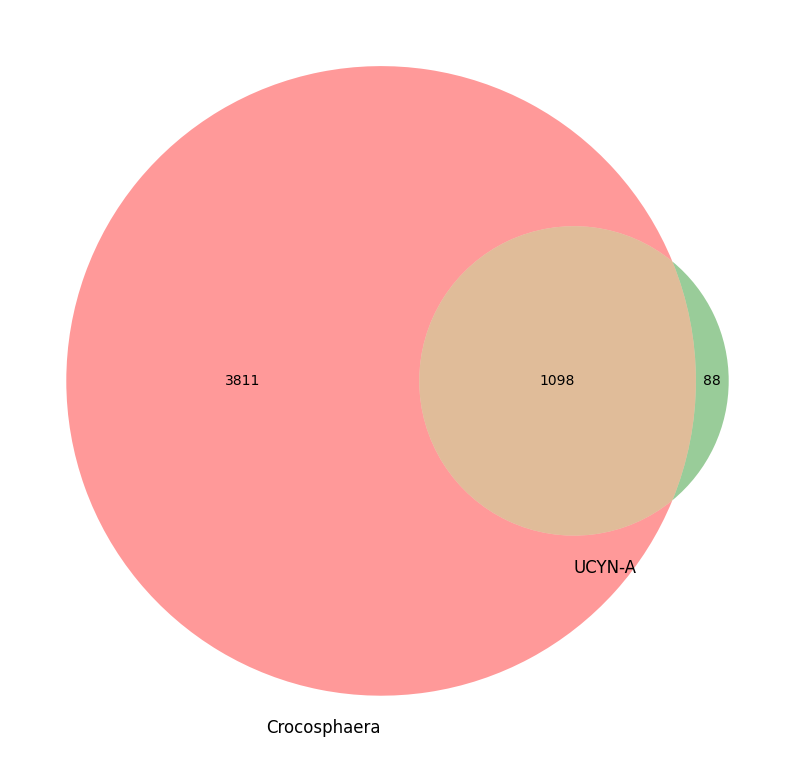

In [24]:
# Create venn diagram of UCYN-A and Crocosphaera proteins
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

crocosphaera_proteins_ids = set([p.id for p in crocosphaera_proteins])
ucyna_crocos_ids = { r["ucyna_gene_id"]: r["crocosphaera_gene_id"] for _, r in rhb_pairs.iterrows() }
ucyna_proteins_ids = set([ucyna_crocos_ids.get(p.id, p.id) for p in ucyna_proteins])

# Create venn diagram of UCYN-A and Crocosphaera proteins with labels
plt.figure(figsize=(10, 10))
venn2([crocosphaera_proteins_ids, ucyna_proteins_ids], set_labels=("Crocosphaera", "UCYN-A"))
plt.savefig("../results/figures/venn_ucyna_crocos.svg", dpi=300)